In [679]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

data = pd.read_csv('../data/car_prices.csv')
data.columns = data.columns.str.replace(' ','_').str.lower()


columns = [
    'make',
    'model',
    'year',
    'engine_hp',
    'engine_cylinders',
    'transmission_type',
    'vehicle_style',
    'highway_mpg',
    'city_mpg',
    'msrp'
]
df = pd.DataFrame(data,columns=columns)

df.isna().sum()
df['engine_hp'].fillna(0,inplace=True)
df['engine_cylinders'].fillna(0,inplace=True)
df.isna().sum()
df['above_average'] = (df['msrp'] >= df['msrp'].mean()).astype(int)
del df['msrp']

In [680]:
SEED = 1
# this really matters! don't use test_size=0.4 and test_size=0.5 to split the test and validation set
# since that will mess with the distribution of the data and the resulting answers
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=SEED)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=SEED)
assert len(df_train) + len(df_val) + len(df_test) == len(df)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.above_average.values
y_val = df_val.above_average.values
y_test = df_test.above_average.values

del df_train['above_average']
del df_val['above_average']
del df_test['above_average']

### Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the `above_average` variable
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['engine_hp']`)

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `engine_hp`
- `engine_cylinders`
- `highway_mpg`
- `city_mpg`

In [681]:
from sklearn.metrics import roc_auc_score
numerical_columns = list(df_train.dtypes[ df_train.dtypes != (object)].index)

scores = {}
for col in numerical_columns:
    auc = roc_auc_score(y_train, df_train[col])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[col])
    scores[col] = round(auc,3)

highest = None
highest_column = None
for k,v in scores.items():
    if highest is None or v > highest:
        highest = v
        highest_column = k
print(f'which column has the highest AUC? {highest_column} at {highest}')

which column has the highest AUC? engine_hp at 0.917


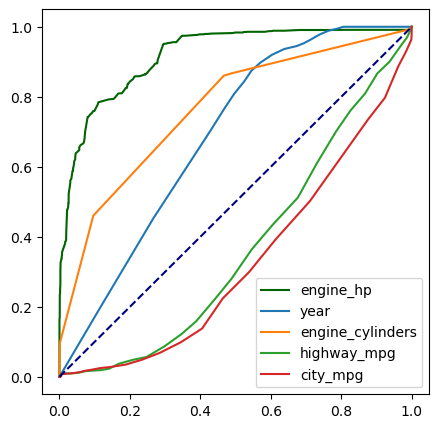

In [682]:
from sklearn.metrics import roc_curve
plt.figure(figsize=(5, 5))

fpr, tpr,_ = roc_curve(y_train, df_train[highest_column])
plt.plot(fpr,tpr,label=highest_column, color='darkgreen')

for col in numerical_columns:
    if col == highest_column:
        continue
    fpr, tpr,_ = roc_curve(y_train, df_train[col])
    plt.plot(fpr,tpr,label=col)
    
#plot the baseline
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

plt.legend()
plt.show()  



### Question 2: Training the model

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```python
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.678
- 0.779
- 0.878
- 0.979

In [683]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer

def train(df_train, y_train, C=1.0):
    dicts = df_train.to_dict(orient='records')
    dv = DictVectorizer()
    X_train = dv.fit_transform(dicts)
    
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

def predict(df_val, dv, model):
    dicts = df_val.to_dict(orient='records')
    X_val = dv.transform(dicts)
    
    y_pred = model.predict_proba(X_val)[:, 1]
    
    return y_pred

dv, model = train(df_train, y_train)
y_pred = predict(df_val, dv, model)
roc_auc_score(y_val, y_pred)

0.976132108676773

### Question 3: Precision and Recall

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?

* 0.28
* 0.48
* 0.68
* 0.88

In [684]:
def compute_confusion_matrix(y_val,y_pred):
    scores = []
    thresholds = np.linspace(0, 1, 101)

    
    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)
        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)
        
        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()
        
        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()
        
        scores.append((t,tp,fp,fn,tn))
    
    columns = ['threshold','tp','fp','fn','tn']
    df_scores = pd.DataFrame(scores,columns=columns)
    return df_scores

dicts = df_val.to_dict(orient='records')
X_val = dv.transform(dicts)
y_pred = model.predict_proba(X_val)[:, 1]

scores = compute_confusion_matrix(y_val, y_pred)

scores[::10]

,threshold,tp,fp,fn,tn
0,0.0,654,1729,0,0
10,0.1,644,358,10,1371
20,0.2,625,226,29,1503
30,0.3,603,156,51,1573
40,0.4,585,112,69,1617
50,0.5,568,72,86,1657
60,0.6,518,52,136,1677
70,0.7,489,29,165,1700
80,0.8,427,14,227,1715
90,0.9,349,4,305,1725


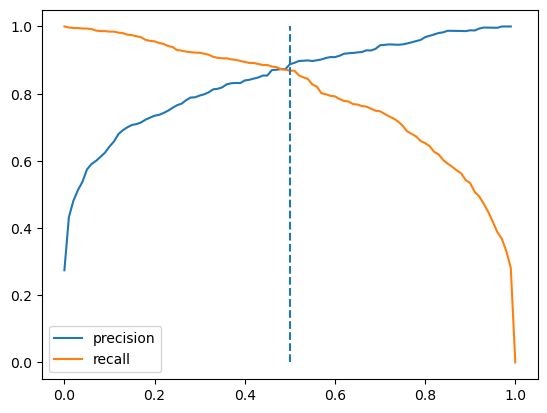

In [685]:
scores['precision'] = scores.tp / (scores.tp + scores.fp)
scores['recall'] = scores.tp / (scores.tp + scores.fn)

plt.plot(scores.threshold, scores.precision, label='precision')
plt.plot(scores.threshold, scores.recall, label='recall')

plt.vlines(x=0.50, ymin=0, ymax=1, linestyles='--')

plt.legend()
plt.show()

### Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.12
- 0.32
- 0.52
- 0.72

In [686]:
scores['f1'] = 2 * scores.precision * scores.recall / (scores.precision + scores.recall)

scores.loc[scores['f1'].argmax()]

threshold       0.510000
tp            568.000000
fp             69.000000
fn             86.000000
tn           1660.000000
precision       0.891680
recall          0.868502
f1              0.879938
Name: 51, dtype: float64

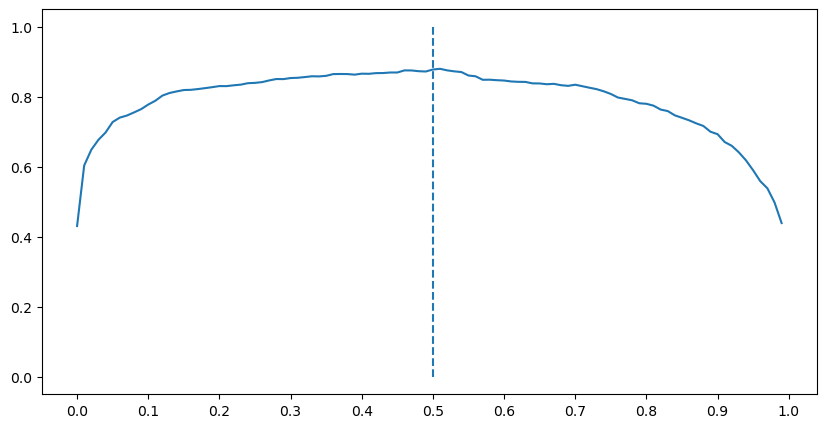

In [687]:
plt.figure(figsize=(10, 5))

plt.plot(scores.threshold, scores.f1, label='f1')
plt.vlines(x=0.5, ymin=0, ymax=1, linestyles='--')

plt.xticks(np.linspace(0, 1, 11))
plt.show()

### Question 5: 5-Fold CV


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

How large is standard deviation of the scores across different folds?

- 0.003
- 0.030
- 0.090
- 0.140

['make', 'model', 'year', 'engine_hp', 'engine_cylinders', 'transmission_type', 'vehicle_style', 'highway_mpg', 'city_mpg']


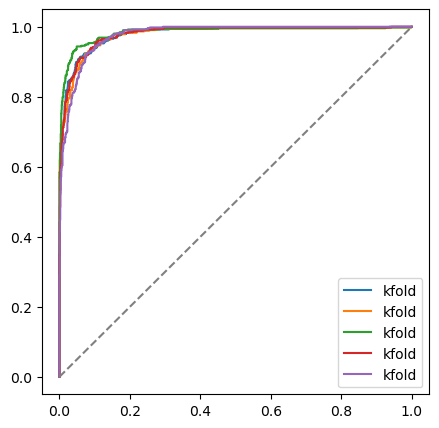

[0.9784891235596623, 0.9774830122707482, 0.9843469410518098, 0.979723662930121, 0.9776903651903652]
0.980 +- 0.003


In [688]:
from sklearn.model_selection import KFold

plt.figure(figsize=(5, 5))

kfold = KFold(n_splits=5, shuffle=True, random_state=1)
columns = [ 'make',
 'model',
 'year',
 'engine_hp',
 'engine_cylinders',
 'transmission_type',
 'vehicle_style',
 'highway_mpg',
 'city_mpg']
print(columns)
scores = []
for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]
    
    y_train = df_train.above_average.values
    y_val = df_val.above_average.values
    
    train_df = df_train[columns]
    val_df = df_val[columns]
    dv, model = train(train_df, y_train, C=1.0)
    y_pred = predict(val_df, dv, model)
    
    auc = roc_auc_score(y_val, y_pred)
    fpr, tpr,_ = roc_curve(y_val, y_pred)
    plt.plot(fpr,tpr,label='kfold')


    scores.append(auc)
    
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')

plt.legend()
plt.show()
print(scores)

print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

### Question 6: Hyperparameter Tuning

Now let's use 5-Fold cross-validation to find the best parameter `C`

* Iterate over the following `C` values: `[0.01, 0.1, 0.5, 10]`
* Initialize `KFold` with the same parameters as previously
* Use these parameters for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which `C` leads to the best mean score?

- 0.01
- 0.1
- 0.5
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest `C`.

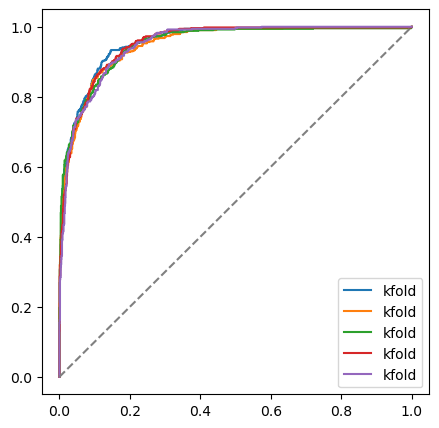

C=0.01 0.952 +- 0.002


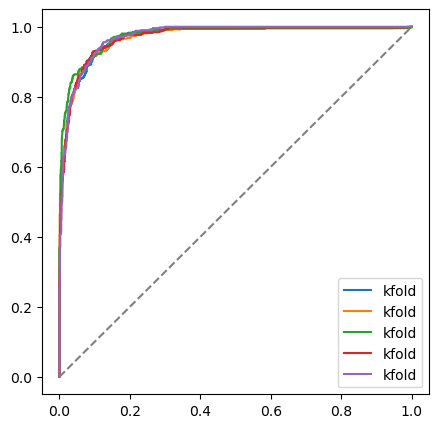

C=0.1 0.972 +- 0.002


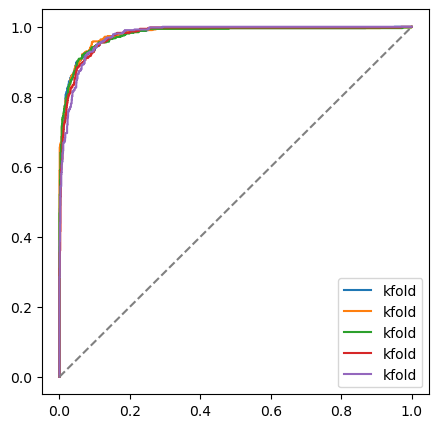

C=0.5 0.978 +- 0.001


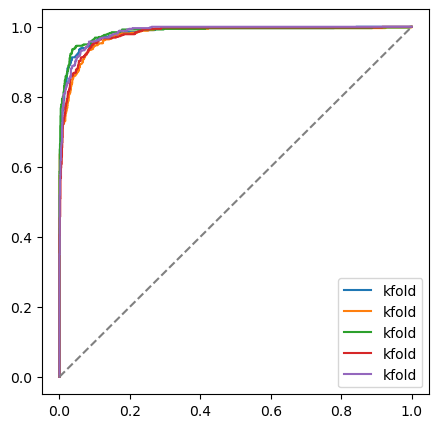

C=10 0.982 +- 0.003


In [689]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for C in [0.01, 0.1, 0.5, 10]:
    scores = []
    plt.figure(figsize=(5, 5))
    for train_idx, val_idx in kfold.split(df_full_train):
        train_df = df_full_train.iloc[train_idx]
        val_df = df_full_train.iloc[val_idx]
        
        y_train = train_df.above_average.values
        y_val = val_df.above_average.values
        
        dv, model = train(train_df[columns], y_train, C=C)
        y_pred = predict(val_df[columns], dv, model)
        fpr, tpr,_ = roc_curve(y_val, y_pred)
        plt.plot(fpr,tpr,label='kfold')
        
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
    plt.plot([0, 1], [0, 1], color='grey', linestyle='--')

    plt.legend()
    plt.show()
    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))